In [4]:
! pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#Importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings("ignore")

In [7]:
#Storing the movie infromation into pandas dataframe

movies = pd.read_csv('movies.csv')

In [20]:
#Displaying the size of movies dataset

movies.shape

(9708, 5)

In [21]:
#Displaying 5 random samples from movies dataset

movies.sample(5)

,movieId,title_year,genres,title,year
5192,8451,Blackboard Jungle (1955),Drama,Blackboard Jungle,1955
5153,8331,"Man Who Came to Dinner, The (1942)",Comedy,"Man Who Came to Dinner, The",1942
2000,2661,It Came from Outer Space (1953),SciFi,It Came from Outer Space,1953
1414,1936,Mrs. Miniver (1942),Drama War,Mrs. Miniver,1942
7567,85774,Senna (2010),Documentary,Senna,2010


In [8]:
def extract_title(title):
    year = title[len(title)-5:len(title)-1]
    if year.isnumeric():
        title_no_year = title[:len(title)-7]
        return title_no_year
    else:
        return title

def extract_year(title):
    year = title[len(title)-5:len(title)-1]
    if year.isnumeric():
        return year
    else:
        return np.nan

movies.rename(columns={'title':'title_year'}, inplace=True) 
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) 
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year)
display(movies.head())

,movieId,title_year,genres,title,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [9]:
r,c = movies[movies['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 34


Text(0, 0.5, 'Counts')

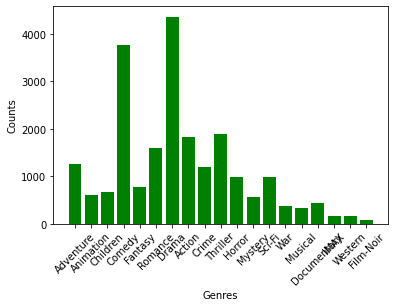

In [10]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in movies.index:
    for g in movies.loc[i,'genres'].split(' '):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

#TF-IDF Function for Content Based Filtering

In [11]:

movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
# create an object for TfidfVectorizer


tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [12]:
tfidf_matrix.shape

(9708, 19)

In [13]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


In [22]:
tfidf_vector.get_feature_names()

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'horror',
 'imax',
 'musical',
 'mystery',
 'noir',
 'romance',
 'scifi',
 'thriller',
 'war',
 'western']

#Building a logic for the Recommender

In [14]:
# create the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix) 
print(sim_matrix)

[[1.         0.8136036  0.15259961 ... 0.         0.42114166 0.26738778]
 [0.8136036  1.         0.         ... 0.         0.         0.        ]
 [0.15259961 0.         1.         ... 0.         0.         0.57070525]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.42114166 0.         0.         ... 0.         1.         0.        ]
 [0.26738778 0.         0.57070525 ... 0.         0.         1.        ]]


In [25]:
# create a function to find the closest title
def matching_score(a,b):
    return fuzz.ratio(a,b)

In [16]:
# a function to convert index to title_year
def get_title_year_from_index(index):
    return movies[movies.index == index]['title_year'].values[0]
# a function to convert index to title
def get_title_from_index(index):
    return movies[movies.index == index]['title'].values[0]
# a function to convert title to index
def get_index_from_title(title):
    return movies[movies.title == title].index.values[0]
# a function to return the most similar title to the words a user type
def find_closest_title(title):
    leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score

In [17]:
def contents_based_recommender(movie_user_likes, how_many):
    result = []
    closest_title, distance_score = find_closest_title(movie_user_likes)
   # When a user does not make misspellings
    if distance_score == 100:
        movie_index = get_index_from_title(closest_title)
        print('Movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
        movie = movies[movies.index == movie_index]
        display(movie[['movieId','title_year','genres']])
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      # remove the typed movie itself
        similar_movies = list(sorted(movie_list,key=lambda x:x[1], reverse=True)) 
      
        for i,s in similar_movies[:how_many]:
            result.append(i)
            #print(get_title_year_from_index(i))
        return result
   # When a user makes misspellings    
    else:
        print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
        print('Movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
        movie_index = get_index_from_title(closest_title)
        movie = movies[movies.index == movie_index]
        display(movie[['movieId','title_year','genres']])
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
        similar_movies = list(sorted(movie_list,key=lambda x:x[1], reverse=True))
        for i,s in similar_movies[:how_many]:
            result.append(i)
            #print(get_title_year_from_index(i))
        return result

#Testing the Recommender

In [18]:
result = contents_based_recommender('Monsters, Inc.', 10)
result_df = pd.DataFrame()
result_df = movies[movies.index.isin(result)][['movieId','title_year','genres']]
display(result_df)
    

Movies similar to Monsters, Inc..



,movieId,title_year,genres
3568,4886,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy


,movieId,title_year,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1706,2294,Antz (1998),Adventure Animation Children Comedy Fantasy
2355,3114,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy
6194,45074,"Wild, The (2006)",Adventure Animation Children Comedy Fantasy
6486,53121,Shrek the Third (2007),Adventure Animation Children Comedy Fantasy
6948,65577,"Tale of Despereaux, The (2008)",Adventure Animation Children Comedy Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure Animation Children Comedy Fantasy


In [19]:
result = contents_based_recommender('Monster Incorporation.', 10)
result_df = pd.DataFrame()
result_df = movies[movies.index.isin(result)][['movieId','title_year','genres']]
display(result_df)

Did you mean Monsters, Inc.? 

Movies similar to Monsters, Inc..



,movieId,title_year,genres
3568,4886,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy


,movieId,title_year,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1706,2294,Antz (1998),Adventure Animation Children Comedy Fantasy
2355,3114,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy
6194,45074,"Wild, The (2006)",Adventure Animation Children Comedy Fantasy
6486,53121,Shrek the Third (2007),Adventure Animation Children Comedy Fantasy
6948,65577,"Tale of Despereaux, The (2008)",Adventure Animation Children Comedy Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure Animation Children Comedy Fantasy
